In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import shutil

import tensorflow as tf

from tensorflow.keras.models import Sequential, load_model, Model
from tensorflow.keras.layers import Dense, Flatten, Input, concatenate
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dropout, MaxPooling2D
from tensorflow.keras.optimizers import SGD, Adam, RMSprop
from tensorflow.keras.layers import Dropout
from keras.callbacks import EarlyStopping
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import GlobalAveragePooling2D
from keras.regularizers import l2
from tensorflow.keras import regularizers

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
import tensorflow.keras.utils as utils

from datetime import datetime

from tensorflow.keras.preprocessing.image import ImageDataGenerator

from google.colab import drive
import zipfile

In [ ]:
drive.mount('/content/drive')

zip_path = '/content/drive/MyDrive/Colab Notebooks/car_part_1800.zip'

re_path = '/content/car_part'

with zipfile.ZipFile(zip_path, 'r') as target_file:
    for file in target_file.namelist():
        file_path = os.path.join(re_path, file)
        if not os.path.exists(file_path):  # 이미 파일이 존재하는 경우 건너뛰기
            target_file.extract(file, re_path)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# train_data = '/content/car_part/car_part/train'
# test_data = '/content/car_part/car_part/test'

# input_shape = (224,224)

# # 데이터 전처리
# train_gen = ImageDataGenerator(rescale=1./255, shear_range=0.2, zoom_range=0.2, horizontal_flip=True)
# test_gen = ImageDataGenerator(rescale=1./255)

# # 학습 및 테스트 데이터셋 로드
# train_dataset = train_gen.flow_from_directory(train_data, target_size=input_shape, batch_size=32, class_mode='categorical')
# test_dataset = test_gen.flow_from_directory(test_data, target_size=input_shape, batch_size=32, class_mode='categorical')

Found 2058 images belonging to 12 classes.
Found 618 images belonging to 12 classes.


In [ ]:
train_data_dir = '/content/car_part/car_part/train'
test_data_dir = '/content/car_part/car_part/test'
image_size = (224, 224)
batch_size = 32

train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1.0/255.0,
                                                                rotation_range=45,
                                                                width_shift_range=0.2,
                                                                height_shift_range=0.2,
                                                                zoom_range=0.2)
train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical'
)

test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1.0/255.0,
                                                                rotation_range=45,
                                                                width_shift_range=0.2,
                                                                height_shift_range=0.2,
                                                                zoom_range=0.2)
test_generator = test_datagen.flow_from_directory(
    test_data_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical'
)

Found 2058 images belonging to 12 classes.
Found 618 images belonging to 12 classes.


In [ ]:
# 모델 구성
model = Sequential()

model.add(Conv2D(32, kernel_size=(3,3), activation='relu', input_shape=(input_shape[0], input_shape[1],3)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, kernel_size=(3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, kernel_size=(3,3), activation='relu'))

model.add(Flatten())

model.add(Dense(64, activation='relu'))
model.add(Dense(12, activation='softmax'))

# 모델 컴파일
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# 모델 학습
start_time = datetime.now()

result = model.fit(x=train_generator, epochs=20, validation_data=test_generator, callbacks=[early_stopping])

end_time = datetime.now()

print('걸린시간:', end_time - start_time)

# 모델 평가
test_loss, test_accuracy = model.evaluate(test_generator)
print(f'Test Loss : {test_loss}')
print(f'Test Accuracy : {test_accuracy}')

Epoch 1/20
65/65 [==============================] - 94s 1s/step - loss: 2.7994 - accuracy: 0.1842 - val_loss: 2.4416 - val_accuracy: 0.1812
Epoch 2/20
65/65 [==============================] - 86s 1s/step - loss: 2.2719 - accuracy: 0.2201 - val_loss: 2.2730 - val_accuracy: 0.2104
Epoch 3/20
65/65 [==============================] - 86s 1s/step - loss: 2.1015 - accuracy: 0.2877 - val_loss: 2.1055 - val_accuracy: 0.3204
Epoch 4/20
65/65 [==============================] - 89s 1s/step - loss: 1.9977 - accuracy: 0.3168 - val_loss: 1.9718 - val_accuracy: 0.3706
Epoch 5/20
65/65 [==============================] - 87s 1s/step - loss: 1.9194 - accuracy: 0.3479 - val_loss: 1.9651 - val_accuracy: 0.3689
Epoch 6/20
65/65 [==============================] - 87s 1s/step - loss: 1.8092 - accuracy: 0.3912 - val_loss: 1.7760 - val_accuracy: 0.4320
Epoch 7/20
65/65 [==============================] - 87s 1s/step - loss: 1.6753 - accuracy: 0.4354 - val_loss: 1.7055 - val_accuracy: 0.4466
Epoch 8/20
65/65 [==

## MobileNet

In [ ]:
base_model = MobileNetV2(input_shape=(image_size[0], image_size[1], 3), include_top=False, weights='imagenet')

model = Sequential()
model.add(base_model)
model.add(GlobalAveragePooling2D())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(4, activation='softmax'))

model.compile(optimizer=Adam(learning_rate=1e-5), loss='categorical_crossentropy', metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

start_time = datetime.now()

result = model.fit(x=train_generator, epochs=70, validation_data=test_generator, callbacks=[early_stopping])

end_time = datetime.now()

print('걸린 시간:', end_time - start_time)

test_loss, test_accuracy = model.evaluate(test_generator)
print(f'Test Loss: {test_loss}')
print(f'Test Accuracy: {test_accuracy}')

Epoch 1/70
1917/5053 [==========>...................] - ETA: 39:26 - loss: 0.6420 - accuracy: 0.8171

KeyboardInterrupt: ignored

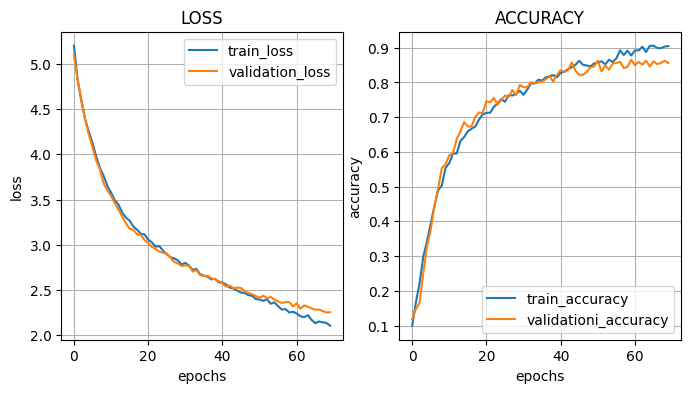

In [ ]:
plt.figure(figsize=(8,4))
plt.subplot(1,2,1)

plt.title('LOSS')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.grid()

plt.plot(result.history['loss'], label='train_loss')
plt.plot(result.history['val_loss'], label= 'validation_loss')
plt.legend(loc='best')

plt.subplot(1,2,2)

plt.title('ACCURACY')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.grid()

plt.plot(result.history['accuracy'], label='train_accuracy')
plt.plot(result.history['val_accuracy'], label= 'validationi_accuracy')
plt.legend(loc='best')


In [ ]:
base_model = MobileNetV2(input_shape=(image_size[0], image_size[1], 3), include_top=False, weights='imagenet')

model = Sequential()
model.add(base_model)
model.add(GlobalAveragePooling2D())
model.add(Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
model.add(Dropout(0.5))
model.add(Dense(12, activation='softmax'))

model.compile(optimizer=Adam(learning_rate=1e-5), loss='categorical_crossentropy', metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

start_time = datetime.now()

result = model.fit(x=train_generator, epochs=70, validation_data=test_generator, callbacks=[early_stopping])

end_time = datetime.now()

print('걸린 시간:', end_time - start_time)

test_loss, test_accuracy = model.evaluate(test_generator)
print(f'Test Loss: {test_loss}')
print(f'Test Accuracy: {test_accuracy}')

Epoch 1/70
65/65 [==============================] - 133s 1s/step - loss: 5.1996 - accuracy: 0.0996 - val_loss: 5.0927 - val_accuracy: 0.1181
Epoch 2/70
65/65 [==============================] - 94s 1s/step - loss: 4.8185 - accuracy: 0.1662 - val_loss: 4.8214 - val_accuracy: 0.1472
Epoch 3/70
65/65 [==============================] - 94s 1s/step - loss: 4.5892 - accuracy: 0.2221 - val_loss: 4.6023 - val_accuracy: 0.1650
Epoch 4/70
65/65 [==============================] - 113s 2s/step - loss: 4.3891 - accuracy: 0.2983 - val_loss: 4.3831 - val_accuracy: 0.2508
Epoch 5/70
65/65 [==============================] - 96s 1s/step - loss: 4.2532 - accuracy: 0.3426 - val_loss: 4.2181 - val_accuracy: 0.3285
Epoch 6/70
65/65 [==============================] - 94s 1s/step - loss: 4.1236 - accuracy: 0.3936 - val_loss: 4.0779 - val_accuracy: 0.3754
Epoch 7/70
65/65 [==============================] - 95s 1s/step - loss: 3.9734 - accuracy: 0.4441 - val_loss: 3.9296 - val_accuracy: 0.4434
Epoch 8/70
65/65 [

In [ ]:
print(tf.__version__)

2.12.0
